In [8]:
file_name = './DARNN_20211127/'

In [9]:
# 모듈 import
from datetime import datetime
import numpy as np
import os
import pandas as pd
import seaborn as sns

#from google.colab import drive
#drive.mount('/content/gdrive')
#os.chdir('/content/gdrive/MyDrive/python/python_dong/data_axis_transform1')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

#!pip install torchmetrics
import torchmetrics

#!pip install torchinfo
from torchinfo import summary

import matplotlib.pyplot as plt
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# data path 지정
raw_data_path = './data/stocknet-dataset/price/raw'

if 'stocknet' in raw_data_path:
    tra_date = '2014-01-02'
    val_date = '2015-08-03'
    tes_date = '2015-10-01'
    end_date = '2015-12-31'
elif 'kdd17' in raw_data_path:
    tra_date = '2007-01-03'
    val_date = '2015-01-02'
    tes_date = '2016-01-04'
    end_date = '2016-12-31'
else:
    print('unexpected path: %s' % raw_data_path)

# os.path.isfile : 파일이 있는지 없는 지 체크
# os.path.join(data_path, fname) : 폴더 디렉터리와 fname(stockname.csv) 붙임
fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

COLUMNS_FEATURE_DATA_V1 = ['open_close_ratio', 'high_close_ratio', 
                           'low_close_ratio', 'close_lastclose_ratio', 
                           'adjclose_lastadjclose_ratio', 'close_ma5_ratio', 
                           'close_ma10_ratio', 'close_ma15_ratio', 'close_ma20_ratio', 
                           'close_ma25_ratio', 'close_ma30_ratio']

ver = 'v1' # ver in ['v1', 'v2']
if ver == 'v1':
    COLUMNS_FEATURE = COLUMNS_FEATURE_DATA_V1

In [11]:
windows = [5,10,15,20,25,30]

def preprocess(df, windows):
   '''
   전처리 함수 역할 : 전체 feature생성하여 df column에 추가
   '''
   data = df
   data['open_close_ratio'] = data['Open'] / data['Close'] - 1
   data['high_close_ratio'] = data['High'] / data['Close'] - 1
   data['low_close_ratio'] = data['Low'] / data['Close'] - 1

   data['close_lastclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'close_lastclose_ratio'] = data['Close'][1:].values / data['Close'][:-1].values - 1

   data['adjclose_lastadjclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'adjclose_lastadjclose_ratio'] = data['Adj Close'][1:].values / data['Adj Close'][:-1].values - 1

   for window in windows:
      data[f'close_ma{window}_ratio'] = data['Adj Close'].rolling(window).mean()/data['Adj Close'] - 1
   
   data['label'] = np.append((data['Close'][1:].values > data['Close'][:-1].values)*1,0)

   return data

In [12]:
feature_data_path = './data/stocknet-dataset/price/feature'

for fname in fnames:
   if not os.path.isfile(os.path.join(feature_data_path,fname)):
      df_raw = pd.read_csv(os.path.join(raw_data_path,fname))
      data = preprocess(df_raw, windows)

      # 폴더 없으면 생성
      try:
         if not os.path.exists(feature_data_path):
            os.makedirs(feature_data_path)
      except OSError:
         print ('Error: Creating directory. ' +  feature_data_path)

      #csv 파일 저장
      data.to_csv(os.path.join(feature_data_path,fname))



In [13]:
raw_data_path = './data/stocknet-dataset/price/raw'


tra_data_X = []
tra_data_Y = []
val_data_X = []
val_data_Y = []
test_data_X = []
test_data_Y = []
tickers = []

cnt = 0
fail_cnt = 0

fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

for fname in fnames:

    df = pd.read_csv(os.path.join(raw_data_path,fname))
    data = preprocess(df, windows)

    learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
    tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
    tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['adjclose_lastadjclose_ratio']
    #tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

    val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
    val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['adjclose_lastadjclose_ratio']
    #val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label'] 

    test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
    test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['adjclose_lastadjclose_ratio']
    #test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']


    if cnt == 0:
        # 첫 티커의 learining_data는 학습 date를 갖는 array
        # 첫 티커의 학습 date를 target_dates로 두고, 다음 티커들은 target_dates와 대조
        # 학습 date가 같으면 학습data에 추가, 아니면 추가하지않음
        # 학습 date가 같으면 vali, test date도 같은걸로 가정
        target_dates = learning_data
    
    print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
    print('X_null data count : train {}, val {}, test {}'
        .format(tra_data_X_ticker.head().isnull().sum().sum(), val_data_X_ticker.head().isnull().sum().sum(), test_data_X_ticker.head().isnull().sum().sum()))
    print('y_null data count : train {}, val {}, test {}'
        .format(tra_data_Y_ticker.head().isnull().sum().sum(), val_data_Y_ticker.head().isnull().sum().sum(), test_data_Y_ticker.head().isnull().sum().sum()))
        
    if np.array_equal(target_dates.values, learning_data.values): 
        
        tra_data_X.append(tra_data_X_ticker.values)
        tra_data_Y.append(tra_data_Y_ticker.values)

        val_data_X.append(val_data_X_ticker.values)
        val_data_Y.append(val_data_Y_ticker.values)
        
        test_data_X.append(test_data_X_ticker.values)
        test_data_Y.append(test_data_Y_ticker.values)

        tickers.append(fname)
    else : 
        fail_cnt += 1
    
    cnt += 1

print(cnt, len(fnames))
print('fail_cnt :', fail_cnt)

'''
# 마지막에 index 종목 넣기
raw_data_index_path = './data/stocknet-dataset/price/raw/index'

fname = os.listdir(raw_data_index_path)[0]

df = pd.read_csv(os.path.join(raw_data_index_path,fname))
data = preprocess(df, windows)

learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['adjclose_lastadjclose_ratio']
#tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['adjclose_lastadjclose_ratio']
#val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['adjclose_lastadjclose_ratio']
#test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']

print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
if np.array_equal(target_dates.values, learning_data.values):
    
    tra_data_X.append(tra_data_X_ticker.values)
    # tra_data_Y.append(tra_data_Y_ticker.values)

    val_data_X.append(val_data_X_ticker.values)
    # val_data_Y.append(val_data_Y_ticker.values)
    
    test_data_X.append(test_data_X_ticker.values)
    # test_data_Y.append(test_data_Y_ticker.values)

    tickers.append(fname)

# tra_data_X
'''

ticker : AAPL.csv, date check : True
X_null data count : train 0, val 0, test 0
y_null data count : train 0, val 0, test 0
ticker : ABB.csv, date check : True
X_null data count : train 0, val 0, test 0
y_null data count : train 0, val 0, test 0
ticker : ABBV.csv, date check : True
X_null data count : train 0, val 0, test 0
y_null data count : train 0, val 0, test 0
ticker : AEP.csv, date check : True
X_null data count : train 0, val 0, test 0
y_null data count : train 0, val 0, test 0
ticker : AGFS.csv, date check : False
X_null data count : train 29, val 0, test 0
y_null data count : train 0, val 0, test 0
ticker : AMGN.csv, date check : True
X_null data count : train 0, val 0, test 0
y_null data count : train 0, val 0, test 0
ticker : AMZN.csv, date check : True
X_null data count : train 0, val 0, test 0
y_null data count : train 0, val 0, test 0
ticker : BA.csv, date check : True
X_null data count : train 0, val 0, test 0
y_null data count : train 0, val 0, test 0
ticker : BABA.csv,

"\n# 마지막에 index 종목 넣기\nraw_data_index_path = './data/stocknet-dataset/price/raw/index'\n\nfname = os.listdir(raw_data_index_path)[0]\n\ndf = pd.read_csv(os.path.join(raw_data_index_path,fname))\ndata = preprocess(df, windows)\n\nlearning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']\ntra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]\ntra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['adjclose_lastadjclose_ratio']\n#tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']\n\nval_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]\nval_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['adjclose_lastadjclose_ratio']\n#val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']\n\ntest_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= 

In [14]:
def list_to_tensor(list_):
    return torch.Tensor(np.array(list_))

In [15]:
tensor_tra_data_X = list_to_tensor(tra_data_X)
tensor_tra_data_Y = list_to_tensor(tra_data_Y).view((len(tra_data_Y),-1,1))
tensor_val_data_X = list_to_tensor(val_data_X)
tensor_val_data_Y = list_to_tensor(val_data_Y).view((len(val_data_Y),-1,1))
tensor_test_data_X = list_to_tensor(test_data_X)
tensor_test_data_Y = list_to_tensor(test_data_Y).view((len(test_data_Y),-1,1))

In [16]:
from torch.autograd import Variable

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


class Encoder(nn.Module):
    """encoder in DA_RNN."""

    def __init__(self, T,
                 input_size,
                 encoder_num_hidden,
                 parallel=False):
        """Initialize an encoder in DA_RNN."""
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.T = T

        # Fig 1. Temporal Attention Mechanism: Encoder is LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )

        # Construct Input Attention Mechanism via deterministic attention model
        # Eq. 8: W_e[h_{t-1}; s_{t-1}] + U_e * x^k
        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T - 1,
            out_features=1
        )

    def forward(self, X):
        """forward.

        Args:
            X: input data

        """
        X_tilde = Variable(X.data.new(
            X.size(0), self.T - 1, self.input_size).zero_())
        X_encoded = Variable(X.data.new(
            X.size(0), self.T - 1, self.encoder_num_hidden).zero_())

        # Eq. 8, parameters not in nn.Linear but to be learnt
        # v_e = torch.nn.Parameter(data=torch.empty(
        #     self.input_size, self.T).uniform_(0, 1), requires_grad=True)
        # U_e = torch.nn.Parameter(data=torch.empty(
        #     self.T, self.T).uniform_(0, 1), requires_grad=True)

        # h_n, s_n: initial states with dimention hidden_size
        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T - 1):
            # batch_size * input_size * (2 * hidden_size + T - 1)
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)

            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T - 1))

            # get weights by softmax
            alpha = F.softmax(x.view(-1, self.input_size))

            # get new input for LSTM
            x_tilde = torch.mul(alpha, X[:, t, :])

            # Fix the warning about non-contiguous memory
            # https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.encoder_lstm.flatten_parameters()

            # encoder LSTM
            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X

        Returns:
            initial_hidden_states
        """
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.encoder_num_hidden).zero_())


class Decoder(nn.Module):
    """decoder in DA_RNN."""

    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        """Initialize a decoder in DA_RNN."""
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)

        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        """forward."""
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T - 1):

            x = torch.cat((d_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T - 1))

            # Eqn. 14: compute context vector
            # batch_size * encoder_hidden_size
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T - 1:
                # Eqn. 15
                # batch_size * 1
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]  # 1 * batch_size * decoder_num_hidden
                c_n = final_states[1]  # 1 * batch_size * decoder_num_hidden

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))

        return y_pred

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X
        Returns:
            initial_hidden_states

        """
        # hidden state and cell state [num_layers*num_directions, batch_size, hidden_size]
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.decoder_num_hidden).zero_())


class DA_rnn(nn.Module):
    """da_rnn."""

    def __init__(self, X, y, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 batch_size,
                 learning_rate,
                 epochs,
                 parallel=False):
        """da_rnn initialization."""
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parallel = parallel
        self.shuffle = False
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator: ", self.device)

        self.Encoder = Encoder(input_size=X.shape[1],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)

        # Loss function
        self.criterion = nn.MSELoss()

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Encoder.parameters()),
                                            lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Decoder.parameters()),
                                            lr=self.learning_rate)

        # Training set
        self.train_timesteps = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_timesteps])
        self.input_size = self.X.shape[1]

    def train(self):
        """training process."""
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            if self.shuffle:
                ref_idx = np.random.permutation(self.train_timesteps - self.T)
            else:
                ref_idx = np.array(range(self.train_timesteps - self.T))

            idx = 0

            while (idx < self.train_timesteps):
                # get the indices of X_train
                indices = ref_idx[idx:(idx + self.batch_size)]
                # x = np.zeros((self.T - 1, len(indices), self.input_size))
                x = np.zeros((len(indices), self.T - 1, self.input_size))
                y_prev = np.zeros((len(indices), self.T - 1))
                y_gt = self.y[indices + self.T]

                # format x into 3D tensor
                for bs in range(len(indices)):
                    x[bs, :, :] = self.X[indices[bs]:(indices[bs] + self.T - 1), :]
                    y_prev[bs, :] = self.y[indices[bs]: (indices[bs] + self.T - 1)]

                loss = self.train_forward(x, y_prev, y_gt)
                self.iter_losses[int(epoch * iter_per_epoch + idx / self.batch_size)] = loss

                idx += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter != 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])

            if epoch % 10 == 0:
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " Loss: ", self.epoch_losses[epoch])

            if epoch % 100 == 0:
                y_train_pred = self.test(on_train=True)
                y_test_pred = self.test(on_train=False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.ioff()
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label="True")
                plt.plot(range(self.T, len(y_train_pred) + self.T),
                         y_train_pred, label='Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred), len(self.y) + 1),
                         y_test_pred, label='Predicted - Test')
                plt.legend(loc='upper left')
                plt.show()

            # # Save files in last iterations
            # if epoch == self.epochs - 1:
            #     np.savetxt('../loss.txt', np.array(self.epoch_losses), delimiter=',')
            #     np.savetxt('../y_pred.txt',
            #                np.array(self.y_pred), delimiter=',')
            #     np.savetxt('../y_true.txt',
            #                np.array(self.y_true), delimiter=',')

    def train_forward(self, X, y_prev, y_gt):
        """
        Forward pass.

        Args:
            X:
            y_prev:
            y_gt: Ground truth label

        """
        # zero gradients
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.Encoder(
            Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
        y_pred = self.Decoder(input_encoded, Variable(
            torch.from_numpy(y_prev).type(torch.FloatTensor).to(self.device)))

        y_true = Variable(torch.from_numpy(
            y_gt).type(torch.FloatTensor).to(self.device))

        y_true = y_true.view(-1, 1)
        loss = self.criterion(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()


    def test(self, on_train=False):
        """test."""

        if on_train:
            y_pred = np.zeros(self.train_timesteps - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_timesteps)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(
                        batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j], batch_idx[j] + self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size

        return y_pred

In [17]:
ticker_idx = 0

In [18]:
X = tra_data_X[ticker_idx]
y = tra_data_Y[ticker_idx]

In [19]:
#X = sample_x
#y = sample_y

batchsize = 128
nhidden_encoder = 128
nhidden_decoder = 128
ntimestep = 10
lr = 0.001
epochs = 10000

==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0004806881964517136


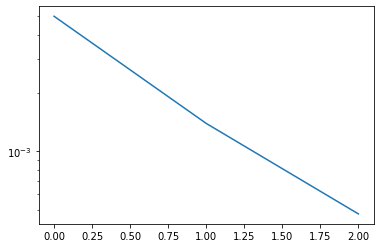

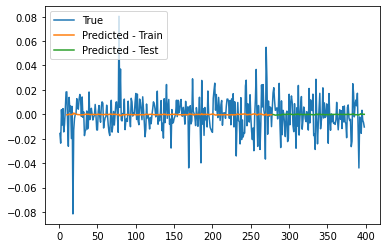

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0007511523241798083


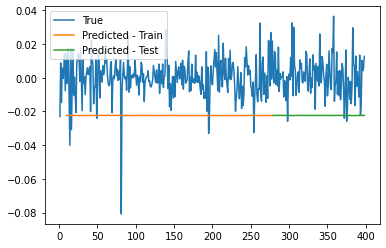

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.001311140270748486


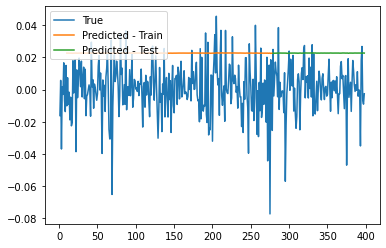

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00047262855514418334


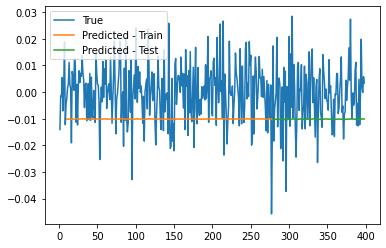

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0016281284576204296


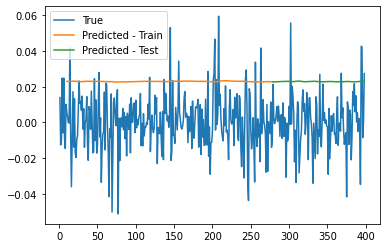

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0017484679313686986


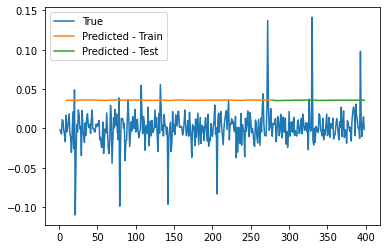

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0005581119718650976


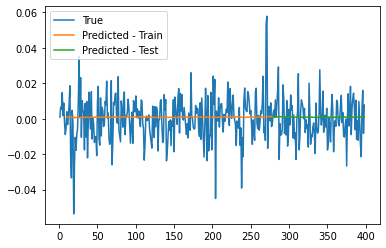

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0036099510422597327


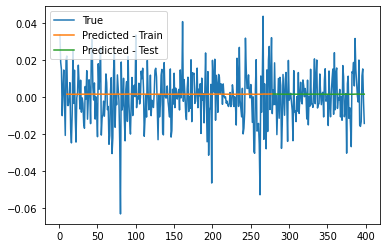

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.002127898818192383


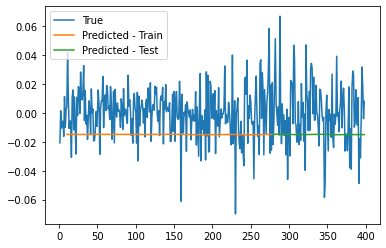

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00043630371025453013


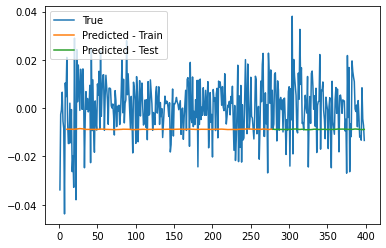

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0018465793885601063


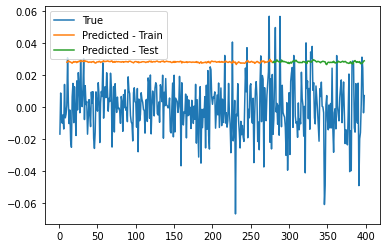

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0006146193093930682


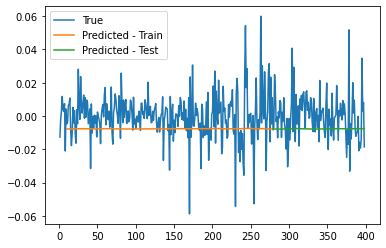

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0008659812980719531


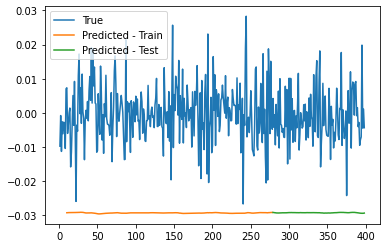

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0010379779948076855


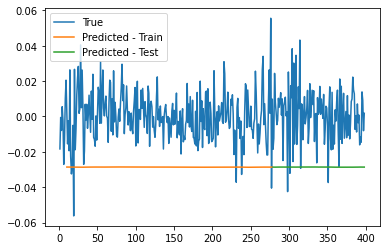

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0015588200330967084


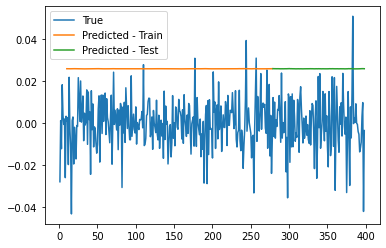

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0010228481648179393


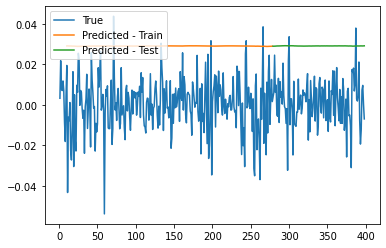

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0011644467886071652


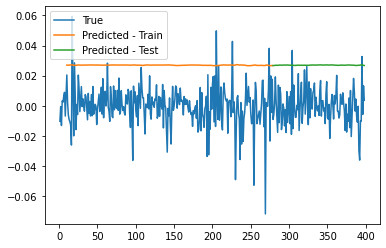

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0037398708518594503


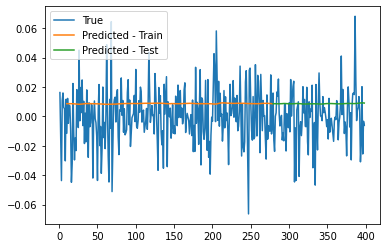

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0005356405745260417


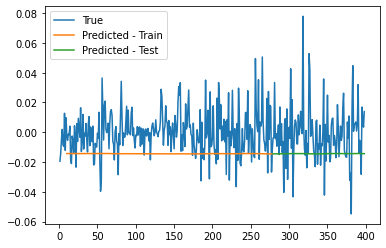

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0011054151206432532


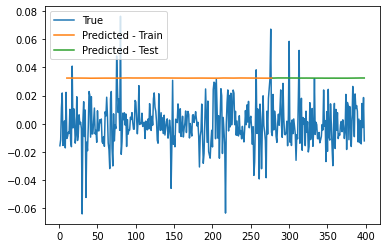

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0003895157715305686


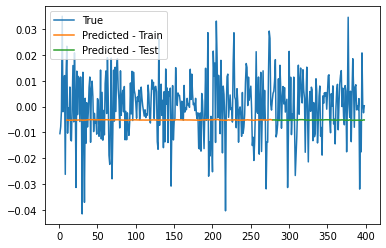

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0007718847822009897


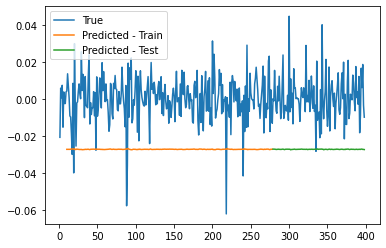

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0007143938613201802


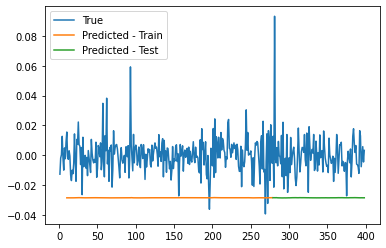

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00047035759780555964


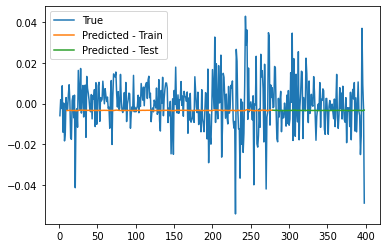

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00038306365604512393


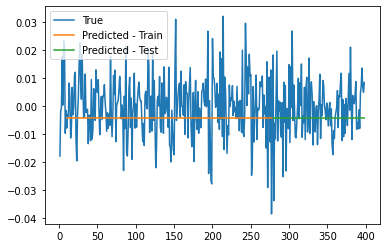

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00034115180703035247


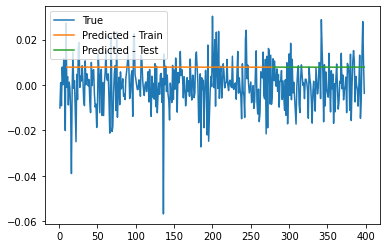

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0007206321461126208


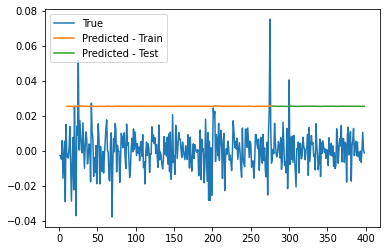

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0003578690520953387


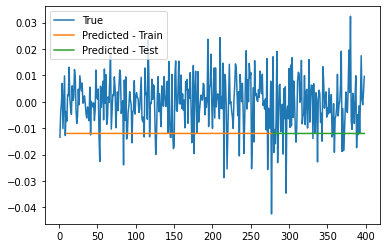

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.002516589612544825


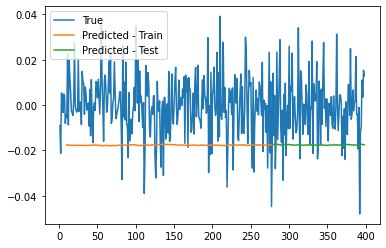

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.004327534911377977


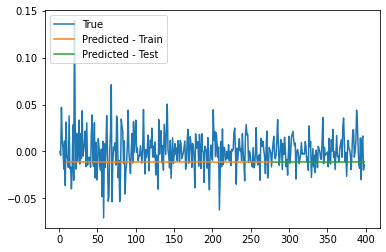

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0007002917021357765


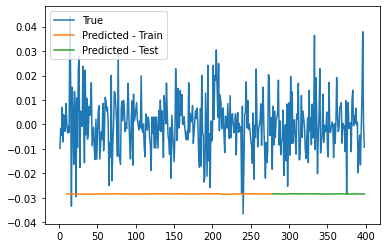

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0019715115583191314


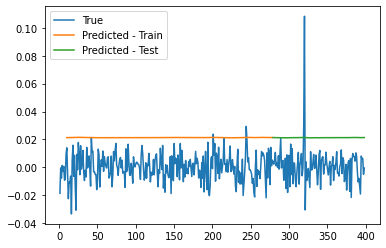

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0005831430316902697


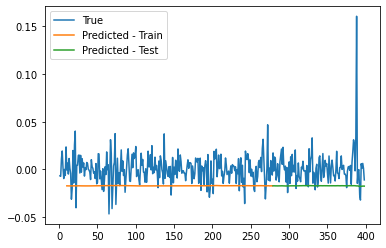

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0004860000820675244


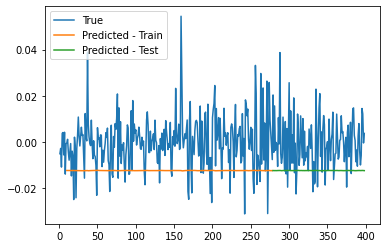

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0003775157529162243


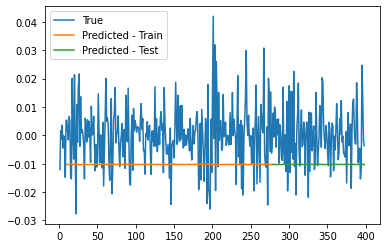

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0021460041753016412


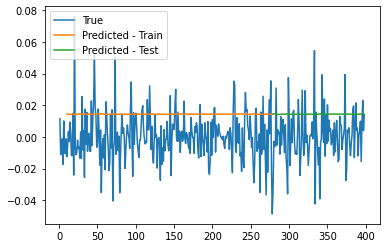

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0011260808678343892


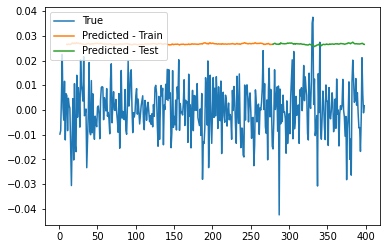

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0005079607896429176


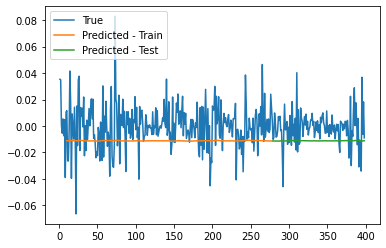

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0011784800929793466


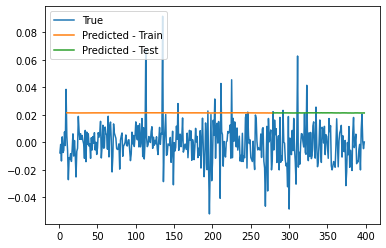

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00045857092724569765


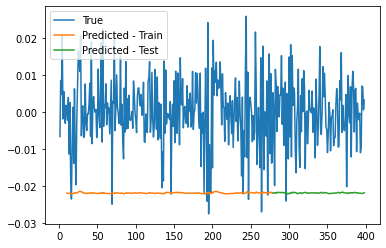

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0003769703422828267


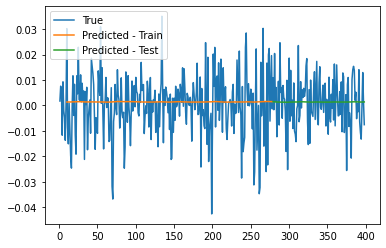

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0026286935656874752


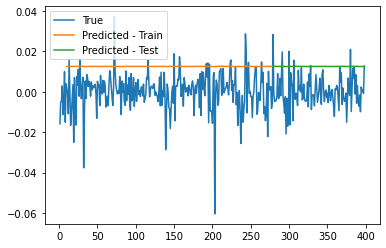

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.005880467593669891


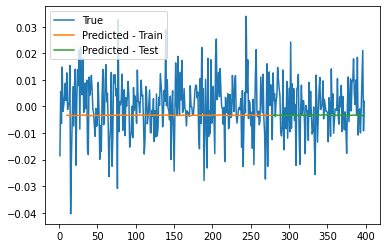

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0004694071103585884


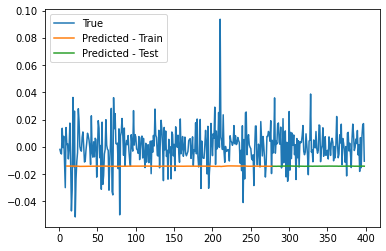

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0003682268240178625


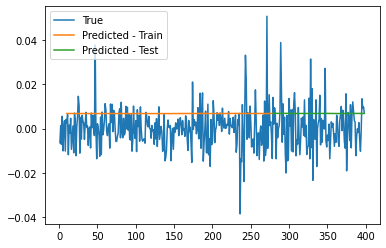

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0015616706126214315


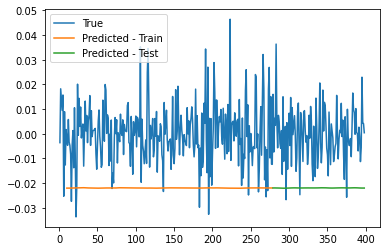

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0013999499424244277


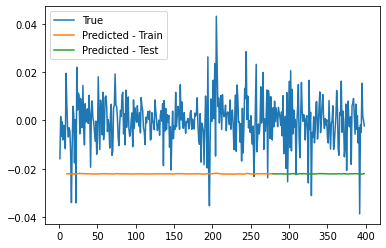

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0012545902864076197


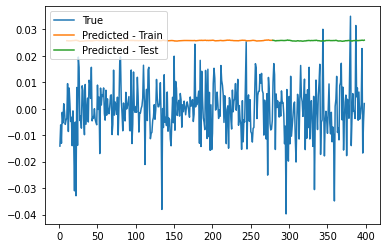

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0007996946224011481


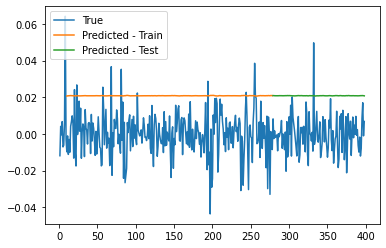

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0015879554557614028


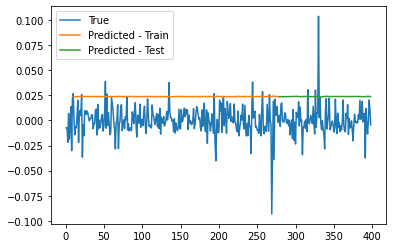

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.000431488937465474


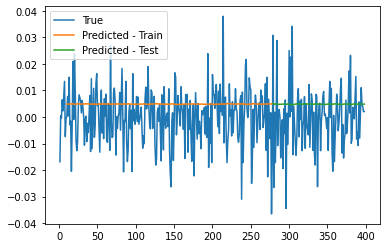

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0012904768518637866


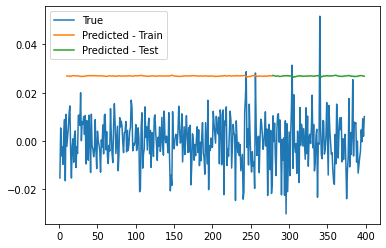

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0015359355117349576


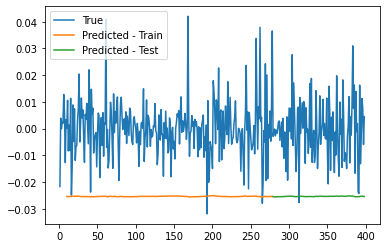

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0010413614800199866


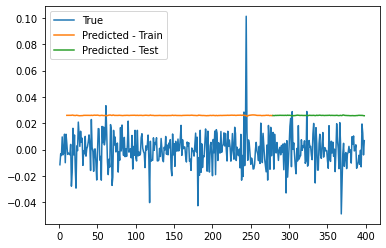

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0004966761892622648


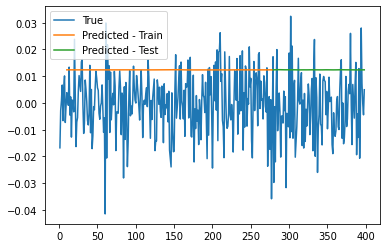

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00045890840313707787


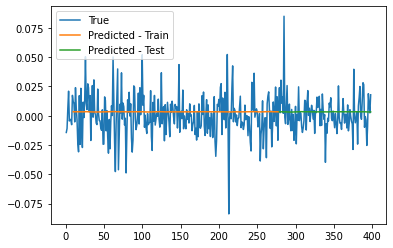

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0005273651840980165


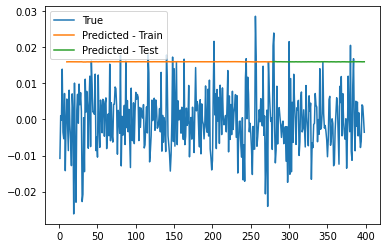

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0005764897044476432


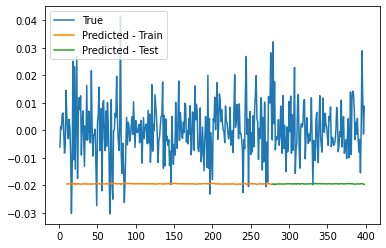

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0002972179014856617


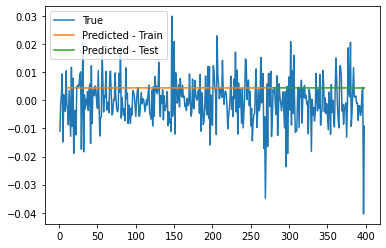

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0007812857705478867


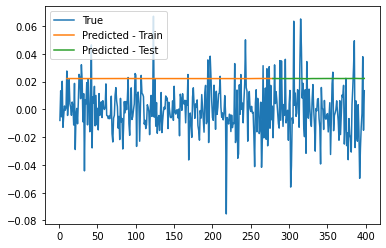

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00042172393780977774


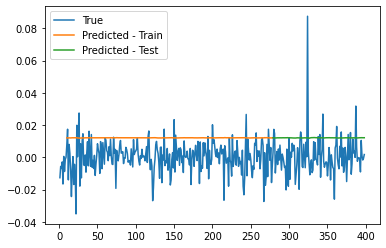

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0013136420651183773


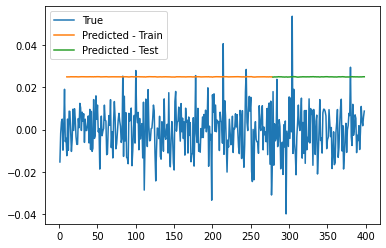

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0008997213638698062


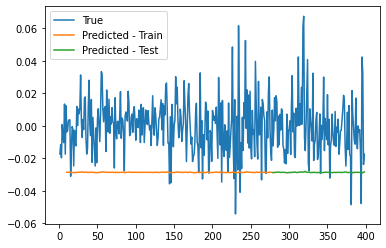

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0005479781927230457


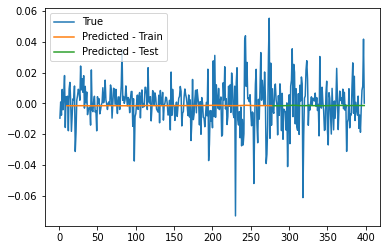

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00136492308229208


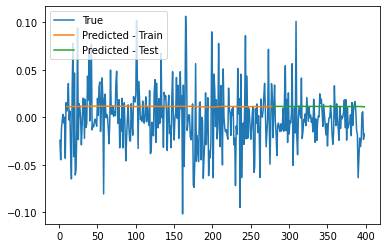

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0012864178570453078


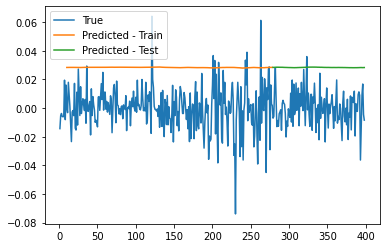

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0005724674847442657


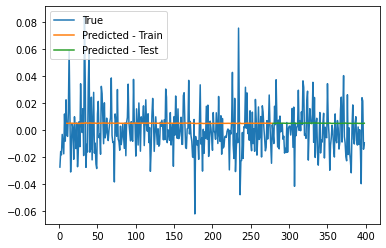

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.008386778567607204


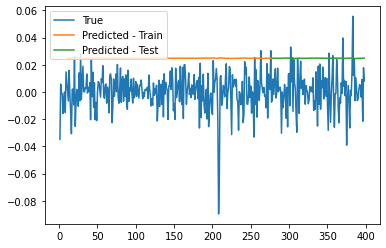

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00209722123205817


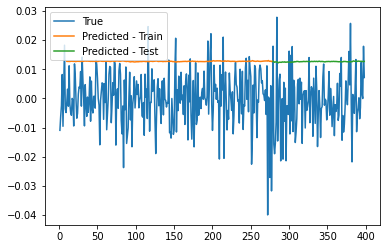

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0012436577817425132


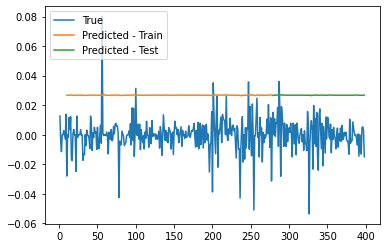

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0010115235345438123


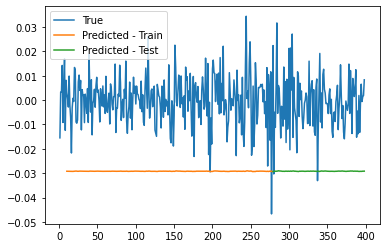

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.004364946954107533


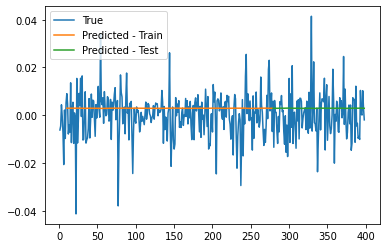

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0006923790012175838


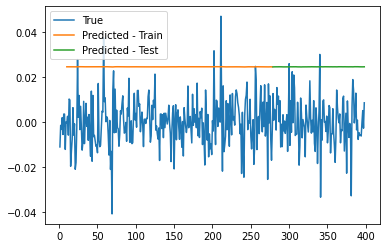

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0007829966877276698


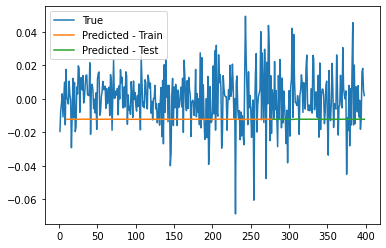

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0008002380976298203


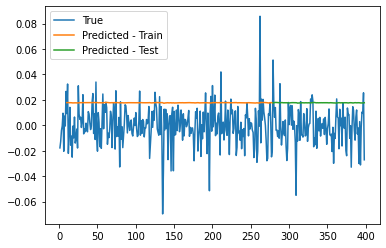

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0011986465445564438


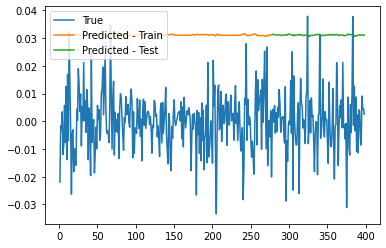

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00046070455088435364


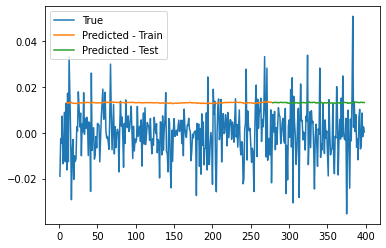

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0007177142009216672


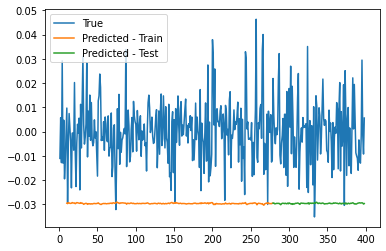

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0008120238441430653


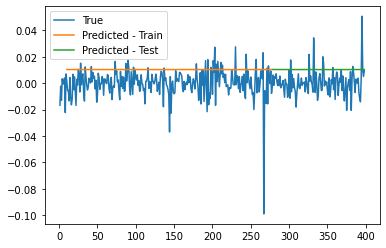

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0008325753345464667


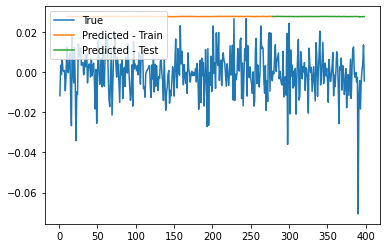

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.00041910311847459525


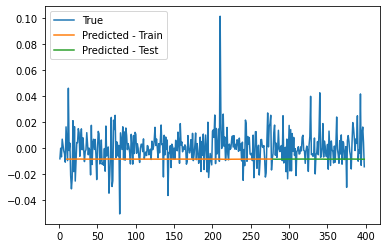

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0005153752499609254


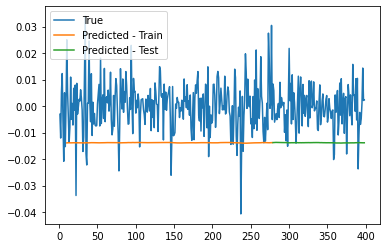

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0002938915810470159


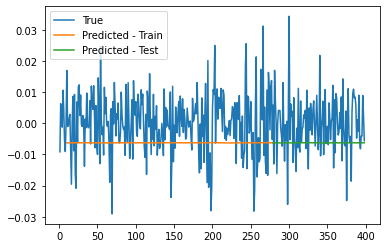

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.000622350261740697


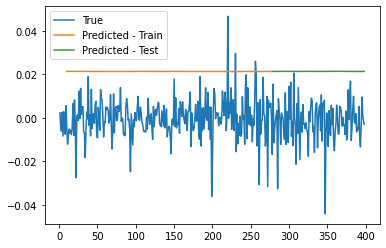

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.0012075324387600024


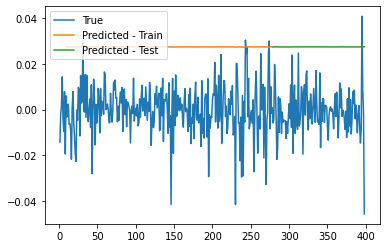

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training


In [21]:
batchsize = 128
nhidden_encoder = 128
nhidden_decoder = 128
ntimestep = 10
lr = 0.001
epochs = 1

# 폴더 없으면 생성
try:
    if not os.path.exists(file_name):
        os.makedirs(file_name)
except OSError:
    print ('Error: Creating directory. ' +  feature_data_path)

for ticker_idx in range(len(tickers)):
    
    X = tra_data_X[ticker_idx]
    y = tra_data_Y[ticker_idx]

    # Initialize model
    print("==> Initialize DA-RNN model ...")
    model = DA_rnn(
        X,
        y,
        ntimestep,
        nhidden_encoder,
        nhidden_decoder,
        batchsize,
        lr,
        epochs
    )

    # Train
    print("==> Start training ...")
    model.train()

    # Prediction
    y_pred = model.test()

    fig1 = plt.figure()
    plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
    plt.savefig(file_name+"iter_losses_{}_{}.png".format(tickers[ticker_idx],ticker_idx))
    plt.close(fig1)

    fig2 = plt.figure()
    plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
    plt.savefig(file_name+"epoch_losses_{}_{}.png".format(tickers[ticker_idx],ticker_idx))
    plt.close(fig2)

    fig3 = plt.figure()
    plt.plot(y_pred, label='Predicted')
    plt.plot(model.y[model.train_timesteps:], label="True")
    plt.legend(loc='upper left')
    plt.savefig(file_name+"test_y_{}_{}.png".format(tickers[ticker_idx],ticker_idx))
    plt.close(fig3)
    print('Finished Training')